In [334]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import scale, robust_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('coolwarm')
sns.set_color_codes('bright')

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel('globalterrorismdb_0522dist.xlsx')

In [285]:
df=data

In [286]:
df.shape

(209706, 135)

In [287]:
null_percentage = df.isnull().sum()/df.shape[0]*100
col_to_drop = null_percentage[null_percentage>30].keys()
output_df = df.drop(col_to_drop, axis=1)
#output_df = output_df.dropna()
output_df

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,National,...,NaN,1.0,0.0,0,0.0,PGIS,0,0,0,0
1,197000000002,1970,0,0,0,130,Mexico,1,North America,Federal,...,NaN,0.0,0.0,0,1.0,PGIS,0,1,1,1
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,Tarlac,...,NaN,1.0,0.0,0,0.0,PGIS,-9,-9,1,1
3,197001000002,1970,1,0,0,78,Greece,8,Western Europe,Attica,...,Unknown Explosive Type,NaN,NaN,1,0.0,PGIS,-9,-9,1,1
4,197001000003,1970,1,0,0,101,Japan,4,East Asia,Fukouka,...,NaN,NaN,NaN,1,0.0,PGIS,-9,-9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209701,202012310015,2020,12,31,0,228,Yemen,10,Middle East & North Africa,Al Hudaydah,...,"Projectile (rockets, mortars, RPGs, etc.)",NaN,NaN,1,0.0,START Primary Collection,0,0,0,0
209702,202012310016,2020,12,31,0,228,Yemen,10,Middle East & North Africa,Al Hudaydah,...,Landmine,NaN,NaN,0,0.0,START Primary Collection,0,0,0,0
209703,202012310017,2020,12,31,0,75,Germany,8,Western Europe,Lower Saxony,...,Arson/Fire,0.0,0.0,1,0.0,START Primary Collection,-9,-9,0,-9
209704,202012310018,2020,12,31,0,4,Afghanistan,6,South Asia,Kabul,...,Unknown Gun Type,1.0,0.0,0,0.0,START Primary Collection,-9,-9,0,-9


In [288]:
print(output_df.columns)

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude',
       'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt',
       'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nwound', 'property',
       'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')


 'weaptype1', 'weapsubtype1', 'nkill', 'nwound', 'property',
       'ishostkid', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'

In [289]:
# 1) print(df['guncertain3'].isnull().sum()) # ruled out . around 2 lakh null values
# 2) print((df['individual']==0).sum()) # ruled out. Around 2 lakh values are zero, leading to low variance
# 2) print(df['individual'].var())
# 3) df['nperps'].var() # ruled out. Very very very high variance 37852.424101420766
# 3) df['nperps'].isnull().sum() # 33% null values
# 4) df['nperpcap'].var() # ruled out. Very very very high variance 37852
# 4) df['nperpcap'].isnull().sum() # 33% null values
# 5) df['claimed'].var() ruled out. Less variance
# df['ishostkid'].isnull().sum()   # included coz it seemed important(might depend on gang)

In [290]:
output_df.describe()

,eventid,iyear,imonth,iday,extended,country,region,latitude,longitude,specificity,...,weaptype1,weapsubtype1,nkill,nwound,property,ishostkid,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,2.097060e+05,209706.000000,209706.000000,209706.000000,209706.000000,209706.000000,209706.000000,205015.000000,205014.000000,209705.000000,...,209706.000000,183765.000000,197179.000000,189770.000000,209706.000000,209528.000000,209706.000000,209706.000000,209706.000000,209706.000000
mean,2.004867e+11,2004.800993,6.455285,15.527930,0.051525,130.291351,7.279854,23.358696,30.416738,1.468387,...,6.543060,11.081294,2.431030,3.085872,-0.712927,0.052967,-4.424289,-4.339318,0.086841,-3.850758
std,1.351933e+09,13.519321,3.387098,8.801104,0.221066,111.714562,2.905697,18.137061,56.113029,0.984958,...,2.296739,6.485577,11.340882,40.916175,3.288812,0.562180,4.543800,4.640302,0.536943,4.677966
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,4.000000,1.000000,-53.154613,-176.176447,1.000000,...,1.000000,1.000000,0.000000,0.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,1.992080e+11,1992.000000,4.000000,8.000000,0.000000,69.000000,6.000000,11.510046,8.748117,1.000000,...,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-9.000000,0.000000,-9.000000
50%,2.012010e+11,2012.000000,6.000000,15.000000,0.000000,98.000000,8.000000,31.300213,43.746215,1.000000,...,6.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.015123e+11,2015.000000,9.000000,23.000000,0.000000,160.000000,10.000000,34.557022,68.835918,1.000000,...,6.000000,16.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.020123e+11,2020.000000,12.000000,31.000000,1.000000,1004.000000,12.000000,74.633553,179.366667,5.000000,...,13.000000,31.000000,1700.000000,10878.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [337]:
output_df.select_dtypes(include='number')
output_df['country'].isnull().sum()

0

In [292]:
number = LabelEncoder()

In [293]:
num_cols = output_df._get_numeric_data().columns
num_cols

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'region',
       'latitude', 'longitude', 'specificity', 'vicinity', 'crit1', 'crit2',
       'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'targtype1', 'targsubtype1', 'natlty1', 'guncertain1', 'individual',
       'weaptype1', 'weapsubtype1', 'nkill', 'nwound', 'property', 'ishostkid',
       'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

In [294]:
list(set(output_df.columns) - set(num_cols))

['corp1',
 'weapsubtype1_txt',
 'attacktype1_txt',
 'city',
 'natlty1_txt',
 'gname',
 'country_txt',
 'provstate',
 'target1',
 'region_txt',
 'weaptype1_txt',
 'targtype1_txt',
 'targsubtype1_txt',
 'dbsource']

weapsubtype4
weaptype4
attacktype3
natlty3
gname
weapsubtype3
weaptype3
attacktype2
weapsubtype2
success
extended
weaptype2
natlty2
suicide
ishostkid
weaptypel
property
related
attacktypel
imonth
iday
INT_MISC
weapsubtypel
targsubtypel
INT_LOG
ransom
INT_IDEO
INT_ANY
iyear
natlty1
region
country

In [295]:
output_df['gname'] = number.fit_transform(output_df['gname'].astype('str'))
output_df['dbsource'] = number.fit_transform(output_df['dbsource'].astype('str'))
output_df['corp1'] = number.fit_transform(output_df['corp1'].astype('str'))
output_df['targtype1_txt'] = number.fit_transform(output_df['targtype1_txt'].astype('str'))
output_df['country_txt'] = number.fit_transform(output_df['country_txt'].astype('str'))
output_df['target1'] = number.fit_transform(output_df['target1'].astype('str'))
output_df['region_txt'] = number.fit_transform(output_df['region_txt'].astype('str'))
output_df['provstate'] = number.fit_transform(output_df['provstate'].astype('str'))
output_df['city'] = number.fit_transform(output_df['city'].astype('str'))
output_df['targsubtype1_txt'] = number.fit_transform(output_df['targsubtype1_txt'].astype('str'))
output_df['natlty1_txt'] = number.fit_transform(output_df['natlty1_txt'].astype('str'))
output_df['attacktype1_txt'] = number.fit_transform(output_df['attacktype1_txt'].astype('str'))
output_df['weapsubtype1_txt'] = number.fit_transform(output_df['weapsubtype1_txt'].astype('str'))
output_df['weaptype1_txt'] = number.fit_transform(output_df['weaptype1_txt'].astype('str'))

In [296]:
output_df = output_df.drop(['targsubtype1','targtype1_txt','targsubtype1_txt','country_txt','region_txt','eventid'], axis=1)

In [297]:
output_df['targtype1']-=1
output_df['targtype1']

0         13
1          6
2          9
3          6
4          6
          ..
209701    13
209702    13
209703     3
209704    13
209705     3
Name: targtype1, Length: 209706, dtype: int64

In [298]:
output_df.loc[output_df['targtype1'] == 19, 'targtype1'] = 22
output_df.loc[output_df['targtype1'] == 20, 'targtype1'] = 19
output_df.loc[output_df['targtype1'] == 21, 'targtype1'] = 20

In [299]:
output_df.loc[output_df['targtype1'] == 22, 'targtype1'] = 21

In [300]:
(output_df['targtype1']==21).sum()

7174

In [301]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#output_df[output_df.columns] = scaler.fit_transform(output_df)

In [302]:
#output_df['crit3']=df['crit3']
output_df.columns

Index(['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'provstate',
       'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1',
       'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide',
       'attacktype1', 'attacktype1_txt', 'targtype1', 'corp1', 'target1',
       'natlty1', 'natlty1_txt', 'gname', 'guncertain1', 'individual',
       'weaptype1', 'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt',
       'nkill', 'nwound', 'property', 'ishostkid', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

weapsubtype4, weaptype4, attacktype3, natlty3, gname, weapsubtype3, weaptype3, attacktype2, weapsubtype2, success, extended, weaptype2, natlty2, suicide, ishostkid, weaptypel, property, related, attacktypel, imonth, iday INT_MISC weapsubtypel targsubtypel INT_LOG ransom INT_IDEO INT_ANY iyear natlty1 region country

In [303]:
train = output_df.loc[output_df['targtype1'] != 21]
test = output_df.loc[output_df['targtype1']==21]

In [304]:
print((output_df['targtype1']==21).sum()/output_df.shape[0])

0.03420979847977645


In [305]:
y = train['targtype1']
X = train.loc[:,train.columns!='targtype1']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)
X
y.unique
y1 = test['targtype1']
y1

36        21
119       21
583       21
615       21
2702      21
          ..
209602    21
209641    21
209646    21
209647    21
209681    21
Name: targtype1, Length: 7174, dtype: int64

In [306]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [307]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [308]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state = None)

In [319]:
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier(max_depth=100)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

In [320]:
y_test

195032     3
75186      3
158743     3
46764      0
46392      1
          ..
84650      0
127304     2
200810    13
23905      1
82048     18
Name: targtype1, Length: 34431, dtype: int64

In [321]:
preds

array([ 3,  3,  3, ..., 13,  1, 13], dtype=int64)

In [322]:
accuracy = accuracy_score(y_test, preds)
accuracy

0.8486538293979263

In [323]:
output_df['targtype1'].unique()

array([13,  6,  9,  2, 19,  3,  1,  5,  0,  7, 20, 14, 21, 18, 17, 11, 15,
        8, 16, 12, 10,  4], dtype=int64)

[1.5793444e-03 6.2546006e-04 5.8269512e-04 1.4029136e-03 1.4217360e-03
 1.4217884e-03 7.7537174e-04 6.5744843e-04 1.0788089e-03 1.3089638e-03
 1.7016362e-03 1.3733039e-03 8.0219982e-03 3.9234892e-02 8.5883099e-01
 1.0803567e-02 3.3322235e-03 1.1215584e-03 1.3924005e-03 4.4794874e-03
 2.1721427e-03 7.6017664e-03 3.7536686e-03 1.9191740e-03 1.7302823e-03
 1.0185010e-03 9.3316752e-04 2.1367907e-03 1.7303491e-03 2.5924994e-03
 1.4563260e-03 9.8981941e-04 1.9141294e-03 1.1402291e-03 2.0336956e-03
 2.1610693e-03 3.9936323e-03 2.2159514e-03 1.4201791e-03 1.4054933e-02
 1.8851202e-03]


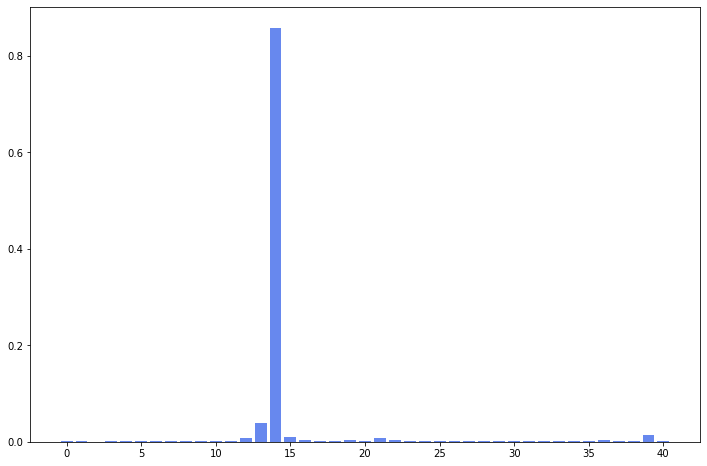

In [324]:
# feature importance
import matplotlib
import matplotlib.pyplot as plt
print(xgb_cl.feature_importances_)
# plot
plt.bar(range(len(xgb_cl.feature_importances_)), xgb_cl.feature_importances_)
plt.show()

In [325]:
X.columns

Index(['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'provstate',
       'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1',
       'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide',
       'attacktype1', 'attacktype1_txt', 'corp1', 'target1', 'natlty1',
       'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1',
       'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nwound',
       'property', 'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC',
       'INT_ANY'],
      dtype='object')

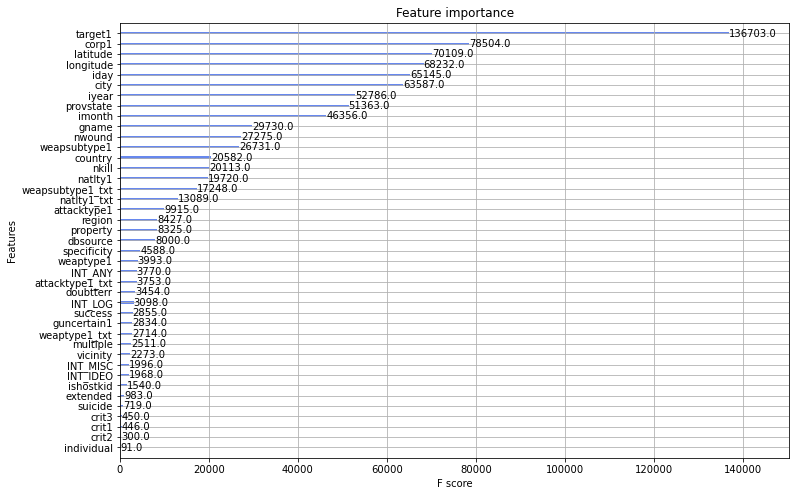

In [326]:
xgb.plot_importance(xgb_cl)
plt.show()

In [327]:
preds = xgb_cl.predict(X_train)

In [328]:
accuracy = accuracy_score(y_train, preds)
accuracy

0.9999583583678859

-------------------------------------------------------------------------- FEATURES SELECTED---------------------------------------------------------------------

In [ ]:
features = [
    'targtype1',
    'corp1',
'longitude',
    'latitude',
   'iyear',
    'city',
'provstate',
    'iday',
 'gname',
'weapsubtype1',
 'natlty1',
 'imonth',
'nwound',
    'nkill',
'country',
'attacktype1',
'dbsource',
  'region',
'property',
'doubtterr',
'INT_MISC',
'specificity',
'weaptype1',
'INT_ANY',
'multiple',
'success',
 'vicinity',
'INT_LOG',
'INT_IDEO',
'guncertain1',
    'crit2',
    'suicide',
    'crit3',
    'extended',
    'crit1',
    'individual'
]
new_df = data[features]
new_df.isnull().sum()
#new_df = new_df.dropna()
# removd corp1 to test if that causes overfitting

In [97]:
new_df.describe()

,targtype1,longitude,latitude,iyear,iday,weapsubtype1,natlty1,imonth,nwound,nkill,...,vicinity,INT_LOG,INT_IDEO,guncertain1,crit2,suicide,crit3,extended,crit1,individual
count,209706.000000,205014.000000,205015.000000,209706.000000,209706.000000,183765.000000,207692.000000,209706.000000,189770.000000,197179.000000,...,209706.000000,209706.000000,209706.000000,209326.000000,209706.000000,209706.000000,209706.000000,209706.000000,209706.000000,209706.000000
mean,8.484078,30.416738,23.358696,2004.800993,15.527930,11.081294,127.079035,6.455285,3.085872,2.431030,...,0.068854,-4.424289,-4.339318,0.075949,0.993291,0.035469,0.866246,0.051525,0.988265,0.003929
std,6.602032,56.113029,18.137061,13.519321,8.801104,6.485577,91.732261,3.387098,40.916175,11.340882,...,0.281308,4.543800,4.640302,0.264916,0.081636,0.184962,0.340389,0.221066,0.107693,0.062561
min,1.000000,-176.176447,-53.154613,1970.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,...,-9.000000,-9.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.748117,11.510046,1992.000000,8.000000,5.000000,78.000000,4.000000,0.000000,0.000000,...,0.000000,-9.000000,-9.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,4.000000,43.746215,31.300213,2012.000000,15.000000,11.000000,101.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,14.000000,68.835918,34.557022,2015.000000,23.000000,16.000000,175.000000,9.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,22.000000,179.366667,74.633553,2020.000000,31.000000,31.000000,1004.000000,12.000000,10878.000000,1700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
new_df.select_dtypes(include='number')

,targtype1,longitude,latitude,iyear,iday,weapsubtype1,natlty1,imonth,nwound,nkill,...,vicinity,INT_LOG,INT_IDEO,guncertain1,crit2,suicide,crit3,extended,crit1,individual
0,14,-69.951164,18.456792,1970,2,NaN,58.0,7,0.0,1.0,...,0,0,0,0.0,1,0,1,0,1,0
1,7,-99.086624,19.371887,1970,0,NaN,21.0,0,0.0,0.0,...,0,0,1,0.0,1,0,1,0,1,0
2,10,120.599741,15.478598,1970,0,NaN,217.0,1,0.0,1.0,...,0,-9,-9,0.0,1,0,1,0,1,0
3,7,23.762728,37.997490,1970,0,16.0,217.0,1,NaN,NaN,...,0,-9,-9,0.0,1,0,1,0,1,0
4,7,130.396361,33.580412,1970,0,NaN,217.0,1,NaN,NaN,...,0,-9,-9,0.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209701,14,43.019490,15.305307,2020,31,11.0,228.0,12,NaN,NaN,...,0,0,0,0.0,1,0,1,0,1,0
209702,14,43.478924,13.931337,2020,31,8.0,228.0,12,NaN,NaN,...,0,0,0,0.0,1,0,1,0,1,0
209703,4,12.374772,51.342239,2020,31,18.0,75.0,12,0.0,0.0,...,0,-9,-9,0.0,1,0,0,0,1,0
209704,14,69.140304,34.523842,2020,31,5.0,4.0,12,0.0,1.0,...,0,-9,-9,0.0,1,0,1,0,1,0


In [99]:
number = LabelEncoder()

In [100]:
num_cols = new_df._get_numeric_data().columns
num_cols

Index(['targtype1', 'longitude', 'latitude', 'iyear', 'iday', 'weapsubtype1',
       'natlty1', 'imonth', 'nwound', 'nkill', 'country', 'attacktype1',
       'region', 'property', 'doubtterr', 'INT_MISC', 'specificity',
       'weaptype1', 'INT_ANY', 'multiple', 'success', 'vicinity', 'INT_LOG',
       'INT_IDEO', 'guncertain1', 'crit2', 'suicide', 'crit3', 'extended',
       'crit1', 'individual'],
      dtype='object')

In [101]:
list(set(new_df.columns) - set(num_cols))

['corp1', 'city', 'gname', 'dbsource', 'provstate']

In [102]:
new_df['gname'] = number.fit_transform(new_df['gname'].astype('str'))
new_df['dbsource'] = number.fit_transform(new_df['dbsource'].astype('str'))
new_df['corp1'] = number.fit_transform(new_df['corp1'].astype('str'))
new_df['city'] = number.fit_transform(new_df['city'].astype('str'))
new_df['provstate'] = number.fit_transform(new_df['provstate'].astype('str'))

In [103]:
new_df

,targtype1,corp1,longitude,latitude,iyear,city,provstate,iday,gname,weapsubtype1,...,vicinity,INT_LOG,INT_IDEO,guncertain1,crit2,suicide,crit3,extended,crit1,individual
0,14,37962,-69.951164,18.456792,1970,36699,1588,2,1994,NaN,...,0,0,0,0.0,1,0,1,0,1,0
1,7,5018,-99.086624,19.371887,1970,27373,711,0,13,NaN,...,0,0,1,0.0,1,0,1,0,1,0
2,10,36305,120.599741,15.478598,1970,42570,2303,0,3587,NaN,...,0,-9,-9,0.0,1,0,1,0,1,0
3,7,37962,23.762728,37.997490,1970,3240,161,0,3587,16.0,...,0,-9,-9,0.0,1,0,1,0,1,0
4,7,37962,130.396361,33.580412,1970,13768,736,0,3587,NaN,...,0,-9,-9,0.0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209701,14,25363,43.019490,15.305307,2020,35374,48,31,1461,11.0,...,0,0,0,0.0,1,0,1,0,1,0
209702,14,25363,43.478924,13.931337,2020,5668,48,31,1461,8.0,...,0,0,0,0.0,1,0,1,0,1,0
209703,4,11897,12.374772,51.342239,2020,23945,1313,31,1934,18.0,...,0,-9,-9,0.0,1,0,0,0,1,0
209704,14,25363,69.140304,34.523842,2020,18917,1021,31,3587,5.0,...,0,-9,-9,0.0,1,0,1,0,1,0


In [104]:
new_df['targtype1']-=1
new_df['targtype1']

0         13
1          6
2          9
3          6
4          6
          ..
209701    13
209702    13
209703     3
209704    13
209705     3
Name: targtype1, Length: 209706, dtype: int64

In [105]:
new_df.loc[new_df['targtype1'] == 19, 'targtype1'] = 22
new_df.loc[new_df['targtype1'] == 20, 'targtype1'] = 19
new_df.loc[new_df['targtype1'] == 21, 'targtype1'] = 20

In [106]:
new_df.loc[new_df['targtype1'] == 22, 'targtype1'] = 21

In [107]:
(new_df['targtype1']==21).sum()

7174

In [108]:
train = new_df.loc[new_df['targtype1'] != 21]
test = new_df.loc[new_df['targtype1']==21]

In [109]:
print((new_df['targtype1']==21).sum()/new_df.shape[0])

0.03420979847977645


In [110]:
y = train['targtype1']
X = train.loc[:,train.columns!='targtype1']
X
print(y.unique)
y1 = test['targtype1']
y1

<bound method Series.unique of 0         13
1          6
2          9
3          6
4          6
          ..
209701    13
209702    13
209703     3
209704    13
209705     3
Name: targtype1, Length: 202532, dtype: int64>


36        21
119       21
583       21
615       21
2702      21
          ..
209602    21
209641    21
209646    21
209647    21
209681    21
Name: targtype1, Length: 7174, dtype: int64

In [111]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [113]:
# Init classifier
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

In [114]:
accuracy = accuracy_score(y_test, preds)
accuracy

0.7535981435307477

--------------RFC--------------